<a href="https://colab.research.google.com/github/abuchin/ML_protein_ligand_prediction/blob/main/ML_protein_binnding_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objectives**

The objective of this Notebook is to train the models based on data processed in the previous step (ML_protein_binnding_data_prep.ipynb).

The overal aim of this work is to:

1) Prepare the training dataset for the models.

2) Traing 4 different models on the same data (Logistic Regression, Random Forest, XgBoost and 2 Layer Neural Network)

3) Analyze results and prediciton accuracy of the proposed algorithms.

4) Compare algorithm performance between each other and compare the accuracy as a function of data size.

#**Import libraries**

In [ ]:

# Standard libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Get ML libraries
from transformers import AutoTokenizer, AutoModel
import torch

# data manipulation
import pickle

# xgboost
from xgboost import XGBClassifier

# import Py-Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# parallel compute
from joblib import parallel_backend


In [ ]:

# save requirements
!pip freeze > requirements_model_build.txt


#**Import processed data**

In [ ]:

# all runs
model_reports_runs = {}


In [ ]:

# reload combined data
shuffled_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/combined_data.csv')

# load protein embeddings
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/protein_embeddings.pkl', 'rb') as f:
    protein_embeddings = pickle.load(f)

# load ligand embeddings
with open('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Data/ligang_data.pkl', 'rb') as f:
    ligang_data_all = pickle.load(f)


In [ ]:

# dictionary to store model results per run
model_reports = {}


**### Prepare data for the models**

In this part we form the training dataset for the models. **features** - for feature matrix and **target_binary** for target variable (binarized binding constant). **n_range** is the length of the training dataset. The whole dataset is ~2M, we processed it in batchess: first 50K, 100K and 500K. Larger values did not fit into the memory (need to be optimized in the future).

In [ ]:

# create features and targets for our values
features = []
target = []
taget_binary = []

# whole dataset
n_all=len(shuffled_data)
n_range = 500000

# form training dataset
for j in range(n_range):

  # We take only these values that are present both in protein and ligand embeddings
  if shuffled_data['UniProt_ID'].iloc[j] in protein_embeddings.keys():
    if int(shuffled_data['pubchem_cid'].iloc[j]) in ligang_data_all.keys():

      # concatenate: protein + ligand features
      features.append(list(protein_embeddings[shuffled_data['UniProt_ID'].iloc[j]])+
                      ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['Fingerprint']+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['MolecularWeight']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['PolarSurfaceArea']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['NumRotatableBonds']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['NumHDonors']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['NumHAcceptors']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['NumAromaticRings']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['FractionCSP3']]+
                      [ligang_data_all[int(shuffled_data['pubchem_cid'].iloc[j])]['BertzComplexity']]
                      )

      # safe kiba_score
      target.append(shuffled_data['kiba_score'].iloc[j])
      taget_binary.append(shuffled_data['bound'].iloc[j])


### Form training dataframe

In this part we create training data dataframes to be used for simpler models training. X stores all combined protein-to-ligand features and y_binary has the binding affinity for all measured pairs. 0 - not bound, 1 - bound.

In [ ]:

# Create training dataframes
X = pd.DataFrame(features)
y = pd.Series(target)
y_binary = pd.Series(taget_binary)


# Train the models

We will build different models with the same data for various sizes of the input data: 10K, 50K, 500K. The input data has been previously shuffled, so we will take examples protein and ligand embeddings. The code has been re-written in object-oriented way to make it easier to use the models later.

##**Logistic regression**

In this part we train logistic regression model on the training set X and binary variable y_binary. We regularize the model using "l2" penalty and predict the test set. Test set is choosen randomly as 20% of the training datasert in X. Then we evaluate the model performance on the test set and plot the confusion matrix.

In [ ]:

class LogisticRegressionModel:
    def __init__(self, penalty='l2', C=1.0, test_size=0.2, random_state=42):
        self.model = LogisticRegression(penalty=penalty, C=C, random_state=random_state)
        self.test_size = test_size
        self.random_state = random_state

    def split_data(self, X, y):
        """Split data into training and testing sets."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, stratify=y, test_size=self.test_size, random_state=self.random_state
        )

    def train(self):
        """Train the model on the training data."""
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        """Make predictions on the test set."""
        self.y_pred = self.model.predict(self.X_test)
        return self.y_pred

    def evaluate(self):
        """Evaluate the model's performance."""
        accuracy = accuracy_score(self.y_test, self.y_pred)
        report = classification_report(self.y_test, self.y_pred)
        cm = confusion_matrix(self.y_test, self.y_pred)

        print('Logistic Regression Evaluation')
        print(f"Accuracy: {accuracy}")
        print(report)
        return accuracy, report, cm

    def plot_confusion_matrix(self, cm, labels=['Not Bound', 'Bound']):
        """Plot the confusion matrix."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.title("Confusion Matrix - Logistic Regression")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()


**Logistic regression: model evaluation**

We could see that after training the model have not learned meaningful representation of the data, since its accuracy is 50%, the same as random chance. The model is predicting the majority of samples as "bound" and makes a lot of errors for "not bound".


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Evaluation
Accuracy: 0.4982005141388175
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       967
           1       0.50      0.53      0.51       978

    accuracy                           0.50      1945
   macro avg       0.50      0.50      0.50      1945
weighted avg       0.50      0.50      0.50      1945



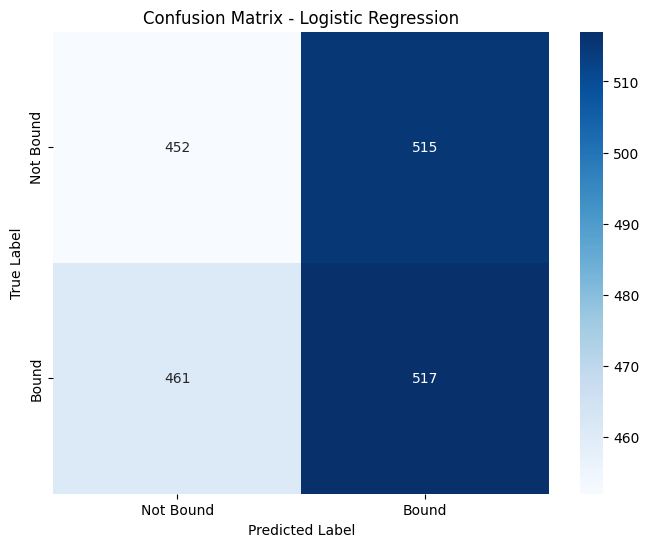

In [ ]:

# Initialize the Logistic Regression model
lr_model = LogisticRegressionModel(penalty='l2', C=1.0, test_size=0.2, random_state=42)
# Split the data
lr_model.split_data(X, y_binary)
# Train the model
lr_model.train()
# Make predictions
lr_model.predict()
# Evaluate the model
accuracy, report, cm = lr_model.evaluate()
# Plot the confusion matrix
lr_model.plot_confusion_matrix(cm)

# add reports
model_reports['Logistic Regression'] = [accuracy, report, cm]


In [ ]:

# save the model
filename = '/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Models/logistic_regression_model_500K.sav'
pickle.dump(lr_model, open(filename, 'wb'))


##**Model: random forest**

Here we develop random forest classifier model with 100 estimators. The model is then trained on features X and binary variable y_binary. We train the model on 80% of X and then evaluate it on randomly choosen subset of 20% of the data. We evaluate the model performance on the test set and plot the confusion matrix.

In [ ]:


class RandomForestModel:

  '''This code describes Random forest classifier re-written in Object-Oriented way'''
  def __init__(self, n_estimators=100, test_size=0.2, random_state=42):
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
        self.test_size = test_size
        self.random_state = random_state

  def split_data(self, X, y):
        """Split data into training and testing sets."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, stratify=y, test_size=self.test_size, random_state=self.random_state
        )

  def train(self):
        """Train the model on the training data."""
        self.model.fit(self.X_train, self.y_train)

  def predict(self):
        """Make predictions on the test set."""
        self.y_pred = self.model.predict(self.X_test)
        return self.y_pred

  def evaluate(self):
        """Evaluate the model's performance."""
        accuracy = accuracy_score(self.y_test, self.y_pred)
        report = classification_report(self.y_test, self.y_pred)
        cm = confusion_matrix(self.y_test, self.y_pred)

        print('Random Forest Evaluation')
        print(f"Accuracy: {accuracy}")
        print(report)
        return accuracy, report, cm

  def plot_confusion_matrix(self, cm, labels=['Not Bound', 'Bound']):
        """Plot the confusion matrix."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.title("Confusion Matrix - Random Forest")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

  def plot_feature_importances(self):
        """Plot feature importances of the model."""
        if hasattr(self.model, "feature_importances_"):
            plt.figure(figsize=(10, 6))
            plt.plot(self.model.feature_importances_, '.')
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.title('Feature Importance (Random Forest)')
            plt.show()
        else:
            print("Model does not have feature importances attribute.")


After fittin the model, we could see that the model is capable of learning this protein-ligand mapping. After training on 500K samples, the model is capable of predicting the test set with 93% accuracy. Compared to 50% random chance, it is significant prediction. The confusion matrix shows that the model makes of nearly equal amount of mis-classifications for bond - not bound and not bound - bound erors, the values off diagonal.

Random Forest Evaluation
Accuracy: 0.9317259119223975
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     48114
           1       0.95      0.91      0.93     48687

    accuracy                           0.93     96801
   macro avg       0.93      0.93      0.93     96801
weighted avg       0.93      0.93      0.93     96801



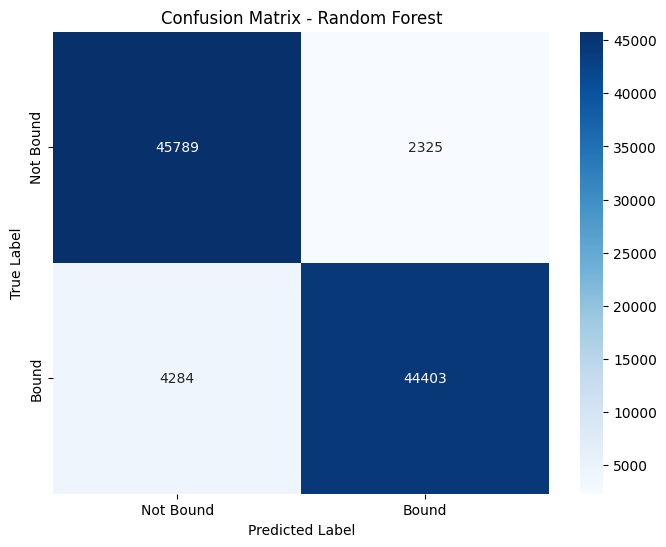

In [ ]:

# Initialize the Random Forest model
rf_model = RandomForestModel(n_estimators=100, test_size=0.2, random_state=42)
# Split the data
rf_model.split_data(X, y_binary)
# Train the model
rf_model.train()
# Make predictions
rf_model.predict()
# Evaluate the model
accuracy, report, cm = rf_model.evaluate()
# Plot the confusion matrix
rf_model.plot_confusion_matrix(cm)

# add reports
model_reports['Random Forest'] = [accuracy, report, cm]


### Plotting random forest features

One could see that ligand molecular features are highly predictive for binding affinities. In particular molecular features of ligands (n_feature > 1024) have the highest accuracy for binding predictions.

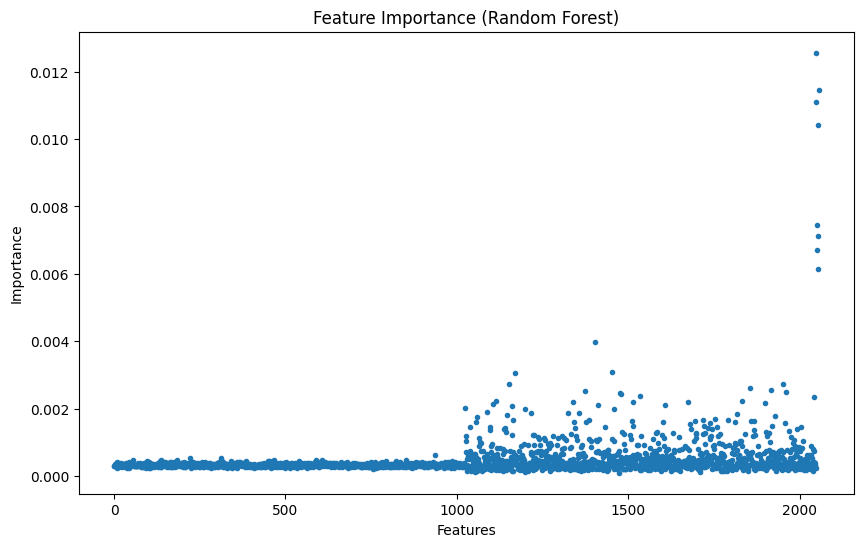

In [ ]:

# Plot feature importances (optional)
rf_model.plot_feature_importances()


In [ ]:

# save the model
filename = '/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Models/random_forest_500K.sav'
pickle.dump(rf_model, open(filename, 'wb'))


##Model: **XgBoost**

In this par the code we trained XGBoost regressor for the training data. Similar to the previous approaches we train the model on 80% of X and predict y_binary. We use 100 estimators in this model and fix the random seed, similar to the previous models. Then we evaluate the model on 20% hold out data from X. In the current version results are shown after training on 500K samples.

In [ ]:

class XgBoost_ClassificationModel:

  '''This code describes using XbGoost classifier re-written in Object-Oriented way'''

    def __init__(self, model, test_size=0.2, random_state=42):
        self.model = model
        self.test_size = test_size
        self.random_state = random_state

    def split_data(self, X, y):
        """Split data into training and testing sets."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, stratify=y, test_size=self.test_size, random_state=self.random_state
        )

    def train(self):
        """Train the model on the training data."""
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        """Make predictions on the test set."""
        self.y_pred = self.model.predict(self.X_test)
        return self.y_pred

    def evaluate(self):
        """Evaluate the model's performance."""
        accuracy = accuracy_score(self.y_test, self.y_pred)
        report = classification_report(self.y_test, self.y_pred)
        cm = confusion_matrix(self.y_test, self.y_pred)

        print('Model Evaluation')
        print(f"Accuracy: {accuracy}")
        print(report)
        return accuracy, report, cm

    def plot_confusion_matrix(self, cm, labels=['Not Bound', 'Bound']):
        """Plot the confusion matrix."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.title("Confusion Matrix - XGBoost")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()


After training on X for 500K samples, the model is capable of predicing the binary outcome y_binary. It could predict the testing set with 81% precision and similar recall values. The XGBoost model makes similar errors for not bound - bound and bound - not bound errors. Therefore the model has similar performance on both classes.

Model Evaluation
Accuracy: 0.8179254346546007
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     48114
           1       0.81      0.83      0.82     48687

    accuracy                           0.82     96801
   macro avg       0.82      0.82      0.82     96801
weighted avg       0.82      0.82      0.82     96801



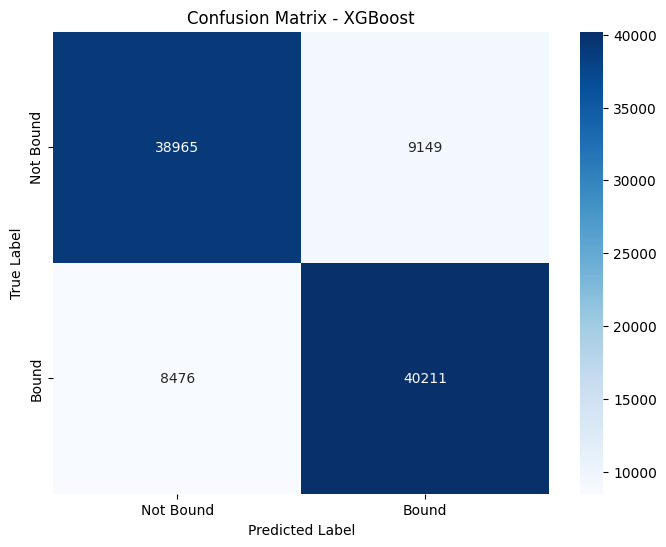

In [ ]:

# initialize
xgb_model = XgBoost_ClassificationModel(XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1))
# Split the data
xgb_model.split_data(X, y_binary)
# Train the model
xgb_model.train()
# Make predictions
xgb_model.predict()
# Evaluate the model
accuracy, report, cm = xgb_model.evaluate()
# Plot the confusion matrix
xgb_model.plot_confusion_matrix(cm)

# add report
model_reports['XGBoost'] = [accuracy, report, cm]


In [ ]:

# save results
filename = '/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Models/xgboost_model_500K.sav'
pickle.dump(xgb_model, open(filename, 'wb'))


## **Model: Multi layer perceptron**

Here we trained the model using fully connected neural network approach. We use 2 layer neural network with fully connected architecture. The hidden layer has ReLU activation function of 256 neuron lenght. On the top layer there is softmax function to predict the binary outcome bound or not. We train the model for 10 epochs with learning rate of 0.001. The model is trained on X and predicts the binary outcome y_binary the same way as the other models. To increase the model speed we put the model and training data and model on CUDA if it is available.

In [ ]:

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class MLPClassifier:
    def __init__(self, input_size, hidden_size=256, output_size=2, batch_size=32, lr=0.001, epochs=10):
        self.model = MLP(input_size, hidden_size, output_size)
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.CrossEntropyLoss()

    def split_data(self, X, y):
        """Split data into training and testing sets and create dataloaders."""
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
        self.train_dataset = MyDataset(X_train, y_train)
        self.test_dataset = MyDataset(X_test, y_test)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        self.y_test = y_test  # Store y_test for evaluation

    def train(self):
        """Train the MLP model."""
        self.model.train()
        for epoch in range(self.epochs):
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.loss_fn(output, target)
                loss.backward()
                self.optimizer.step()

    def evaluate(self):
        """Evaluate the model on the test set."""
        self.model.eval()
        y_pred = []
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                _, predicted = torch.max(output, 1)
                y_pred.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(self.y_test, y_pred)
        report = classification_report(self.y_test, y_pred)
        cm = confusion_matrix(self.y_test, y_pred)

        print('MLP Evaluation')
        print(f"Accuracy: {accuracy}")
        print(report)
        return accuracy, report, cm

    def save(self, path):
        """Save the model's state dictionary."""
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        """Load the model's state dictionary."""
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.to(self.device)
        print(f"Model loaded from {path}")

    def plot_confusion_matrix(self, cm, labels=['Not Bound', 'Bound']):
        """Plot the confusion matrix."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.title("Confusion Matrix - MLP (PyTorch)")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

After training for 10 epochs on the dataset, we found only minor improvements of the model performance. Once the model is trained it could distinguish bound vs not bound only with 52% accuracy, which is near chance of 50%. It seems that the model is highly biased after training, it predict the majority of samples as bound even when they are not bound. It is likely that normalization of the training data, increasing the learning rate or training for longer times might improve the model performance.

MLP Evaluation
Accuracy: 0.5221743577029163
              precision    recall  f1-score   support

           0       0.86      0.05      0.09     48114
           1       0.51      0.99      0.68     48687

    accuracy                           0.52     96801
   macro avg       0.69      0.52      0.38     96801
weighted avg       0.69      0.52      0.38     96801



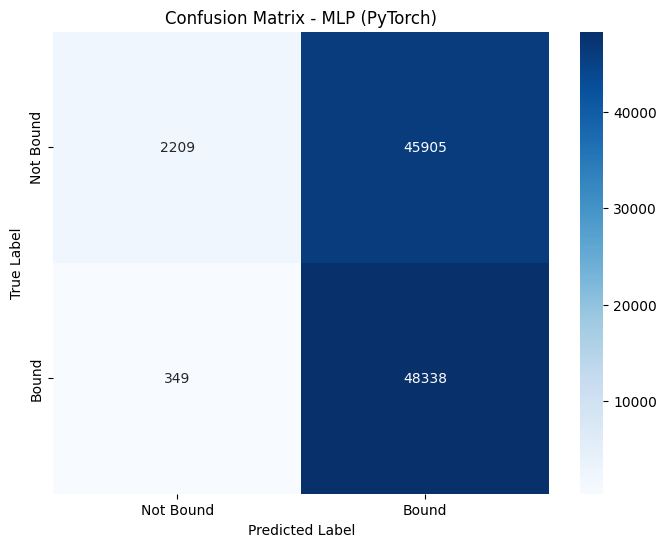

In [ ]:

# Initialize the MLP classifier with relevant parameters
input_size = X.shape[1]
mlp_classifier = MLPClassifier(input_size=input_size, hidden_size=256, output_size=2, batch_size=32, lr=0.001, epochs=10)
# Split the data
mlp_classifier.split_data(X, y_binary)
# Train the model
mlp_classifier.train()
# Evaluate the model
accuracy, report, cm = mlp_classifier.evaluate()
# Plot the confusion matrix
mlp_classifier.plot_confusion_matrix(cm)

# Save model report
model_reports['MLP'] = [accuracy, report, cm]


In [ ]:

# Save MLP model
mlp_classifier.save('/content/drive/MyDrive/Colab Notebooks/Deloitte_project/Models/mlp_model_500K.pth')


Model saved to /content/drive/MyDrive/Colab Notebooks/Deloitte_project/Models/mlp_model_500K.pth


#**Model comparisons**

In this part of the Notebook we compare the model performances between each other. In order to run this comparisons you should run the code above for 10K, 50K or 500K samples (n_range). Once these computations are done, you cold save the models and reports to model_reports_runs, where I save the dictionary for every individual model report (model_reports).

In [ ]:

# save model reports into dictionary
model_reports_runs['10K'] = model_reports.copy()


### 10K examples

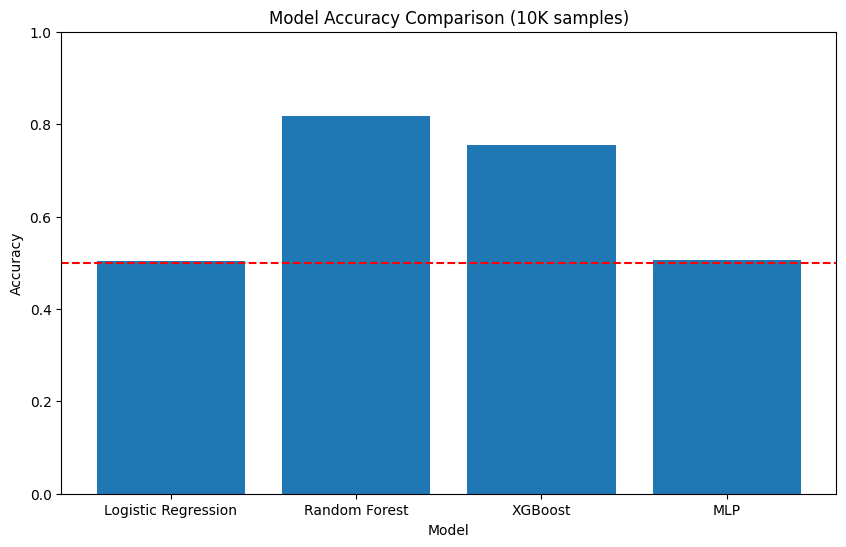

In [ ]:

# Extract accuracy scores for each model
accuracy_scores = [model_reports_runs['10K']['Logistic Regression'][0],
                   model_reports_runs['10K']['Random Forest'][0],
                   model_reports_runs['10K']['XGBoost'][0],
                   model_reports_runs['10K']['MLP'][0]]

# Model names
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(model_names, accuracy_scores)
# added baseline
plt.axhline(y=0.5, color='r', linestyle='--', label='Baseline (0.5)')  # Add baseline at 0.5
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Model Accuracy Comparison (' + str('10K') +str(' samples)'))
plt.show()



### 50K examples

In [ ]:

# save
model_reports_runs['50K']=model_reports.copy()


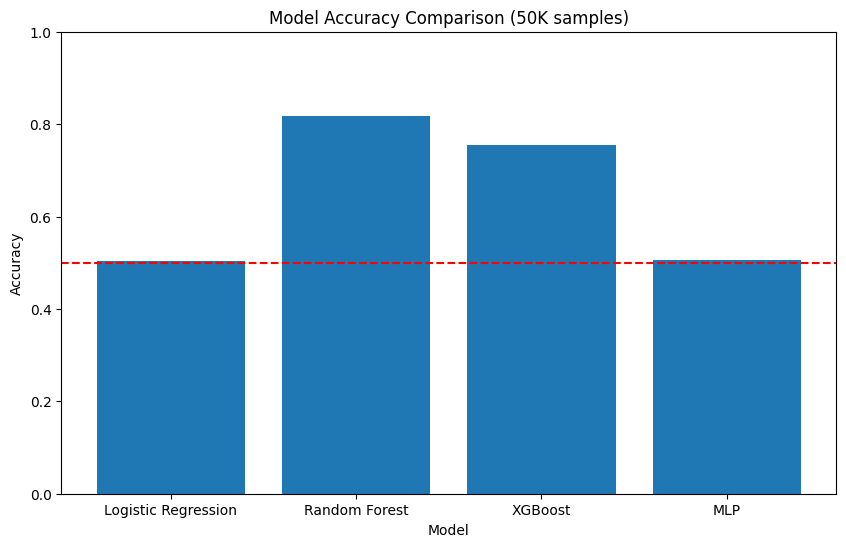

In [ ]:

# Extract accuracy scores for each model
accuracy_scores = [model_reports_runs['50K']['Logistic Regression'][0],
                   model_reports_runs['50K']['Random Forest'][0],
                   model_reports_runs['50K']['XGBoost'][0],
                   model_reports_runs['50K']['MLP'][0]]

# Model names
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(model_names, accuracy_scores)
# added baseline
plt.axhline(y=0.5, color='r', linestyle='--', label='Baseline (0.5)')  # Add baseline at 0.5
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Model Accuracy Comparison (' + str('50K') +str(' samples)'))
plt.show()


### 500K samples

In [ ]:

# save
model_reports_runs['500K']=model_reports.copy()


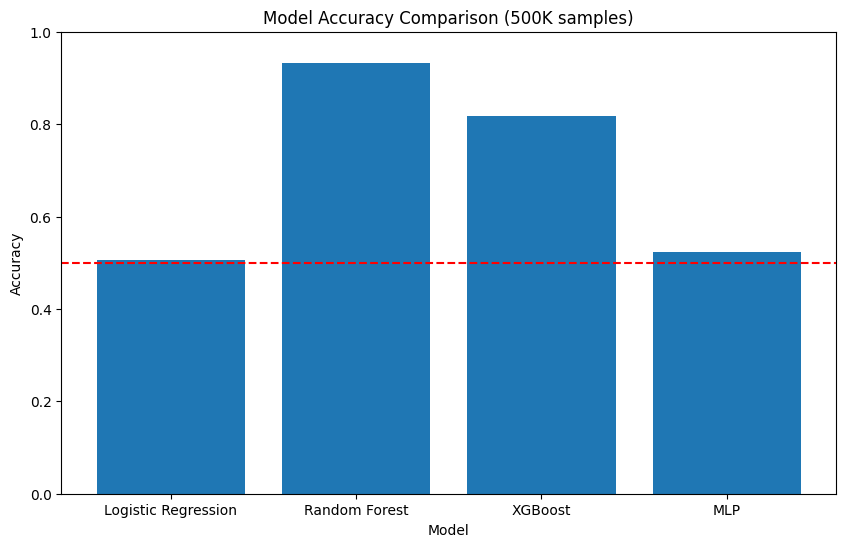

In [ ]:

# Extract accuracy scores for each model
accuracy_scores = [model_reports_runs['500K']['Logistic Regression'][0],
                   model_reports_runs['500K']['Random Forest'][0],
                   model_reports_runs['500K']['XGBoost'][0],
                   model_reports_runs['500K']['MLP'][0]]

# Model names
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(model_names, accuracy_scores)
# added baseline
plt.axhline(y=0.5, color='r', linestyle='--', label='Baseline (0.5)')  # Add baseline at 0.5
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Model Accuracy Comparison (' + str('500K') +str(' samples)'))
plt.show()


### Compare model performances for different sample sizes

We see that when the dataset size goes larger, we could see better performace for Random Forest, Gradient Boosting, XGBoost and MLP algorithms. Random forest is still the best algorithm for this problem in terms of accuracy, followed by XgBoost. MLP model provides only minor improvement after 500K samples.

**Resource problem:** We have found a ceiling in the current implementation of the model on Google Colab (could not find instances with enough memory). The maximal memory instance size had 80 GB of memory, which was not enough for 2M dataset. Therefore the maximum sample size we have processed is 500K. However it was important to show the model improvements over time given the resources we had.

**Alternative solutions:** Given the limited amount of time, I did not have time to explore more batch-based solutions to fit only subsets of memory into the data for every batch of model training. This would be an alternative approach to loading the whole matrix X into the memory.

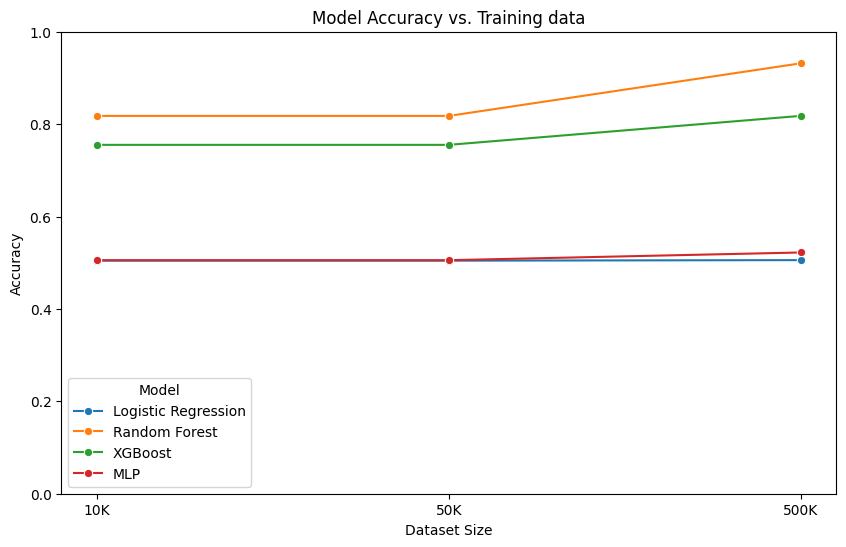

In [ ]:

# Create a DataFrame for plotting
data = []
for dataset_size, model_reports in model_reports_runs.items():
  for model, report in model_reports.items():
    # Accuracy is the first element
      data.append([dataset_size, model, report[0]])

df = pd.DataFrame(data, columns=['Dataset Size', 'Model', 'Accuracy'])

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Dataset Size', y='Accuracy', hue='Model', data=df, marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Training data')
plt.ylim([0, 1])  # Set y-axis limit
plt.show()
